In [1]:
import tensorflow.compat.v1 as tf1
# import tensorflow as tf2
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
config = tf1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.1
session = tf1.Session(config=config)

2024-10-24 02:47:52.630975: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-24 02:47:52.675350: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-24 02:47:53.456013: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-10-24 02:47:54.847021: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4033 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:3b:00.0, compute capabi

# 1. 필요 데이터 불러오기

### 1-1. Bone Fracture Image Data
* "**2. 데이터 전처리**" 코드 참고해서 JPG 이미지를 numpy 형식으로 변환한 npy 파일을 불러왔습니다.
* 아래에서 모델에 맞게 변환할 예정입니다.

In [4]:
import os
import cv2
import numpy as np

# npy 데이터 load 후 shape 출력
All_npy_224 = np.load("./allnpy224.npy")
print(All_npy_224.shape)

(4083, 224, 224)


### 1-2. Localization Label Data
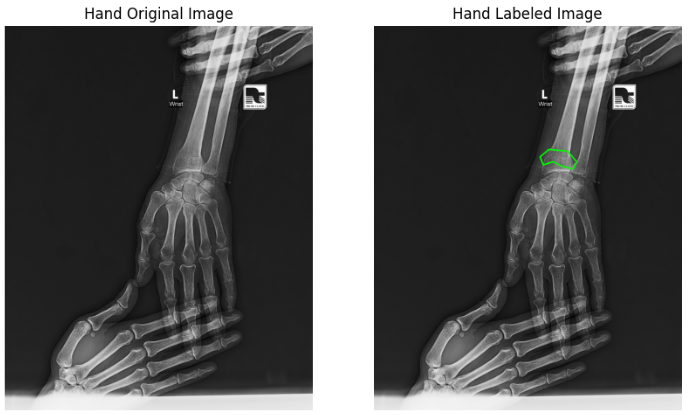
* **VGG_fracture_masks.json** 데이터는 위의 사진처럼 Localization을 위한 Label이기 때문에 Segmentation을 위한 Polygon 안 쪽을 채운 Label Data가 필요합니다.

In [9]:
import json

with open("./data/VGG_fracture_masks.json", "r") as f:
    json_data = json.load(f)
    
print(json_data["IMG0000019.jpg"])

{'fileref': '', 'size': 770034, 'filename': 'IMG0000019.jpg', 'base64_img_data': '', 'file_attributes': {}, 'regions': {'0': {'shape_attributes': {'name': 'polygon', 'all_points_x': [1266.0594059405942, 1339.7227722772277, 1401.5049504950496, 1489.4257425742576, 1515.5643564356437, 1449.0297029702972, 1308.8316831683169, 1242.2970297029703, 1266.0594059405942], 'all_points_y': [1045.5445544554457, 1021.782178217822, 1052.673267326733, 1076.4356435643565, 1021.782178217822, 943.3663366336635, 929.1089108910893, 986.1386138613863, 1045.5445544554457]}, 'region_attributes': {'label': 'fractured'}}}}


# 2. Label Data : Localization ➡️ Segmentation
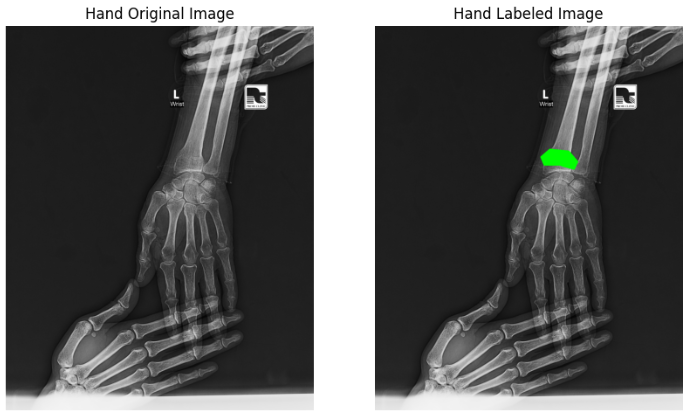


* Label Data를 아래 이미지와 같이 변경하게 되면 Segmentation을 위한 데이터를 완성
* FracAtlas 데이터의 골절 라벨링된 부분을 보면 골절 부분을 정확히 라벨링 한 것이 아니라 그 주변을 라벨링 해 놓았기에 이와 같이 polygon 안 쪽을 채운 라벨 데이터를 만들게 되었을 때 Bounding Box 같은 정보보다 골절 부분을 더 세밀하게 레이블 하게 되어 골절을 찾는 다는 목적에 더 부합하다고 생각하여 이렇게 라벨링을 진행하였습니다.


### 2-1. Polygon 안 쪽을 채우고 채워진 부분의 좌표 추출
1. fillPoly를 사용하여 기존에 주어진 polygon 안 족을 255로 채워주었습니다.
2. 그 다음 255 부분을 찾아 그 부분의 좌표를 저장하였습니다.
3. 그렇게 모아진 좌표 데이터를 segmentation_data.json 파일로 저장하였습니다.

In [46]:
import json
import numpy as np
import cv2  # cv2가 있어야 fillPoly()를 사용 가능

# 경로 설정
json_path = "./data/VGG_fracture_masks.json"  # 기존 JSON 파일 경로
segmentation_output = "./data/segmentation_data.json"  # 세그멘테이션 데이터를 저장할 경로

# VGG JSON 데이터 로드
with open(json_path, "r") as f:
    json_data = json.load(f)

# 세그멘테이션 데이터를 저장할 딕셔너리
segmentation_data = {}

# JSON 데이터의 각 이미지를 처리
for img_file, img_info in json_data.items():
    
    # 각 이미지에 대해 폴리곤 좌표 처리
    for region in img_info['regions'].values():
        shape_attributes = region['shape_attributes']
        
        # 폴리곤 좌표 추출
        if shape_attributes['name'] == 'polygon':
            all_points_x = shape_attributes['all_points_x']
            all_points_y = shape_attributes['all_points_y']
            polygon_points = np.array(list(zip(all_points_x, all_points_y)), np.int32)
            
            # 빈 캔버스 생성 (최소 크기로 설정) -> 정수형으로 변환
            canvas_width = int(max(all_points_x)) + 1
            canvas_height = int(max(all_points_y)) + 1
            mask = np.zeros((canvas_height, canvas_width), dtype=np.uint8)
            
            # 폴리곤 내부를 흰색(255)으로 채우기
            cv2.fillPoly(mask, [polygon_points], color=255)
    
            # 채워진 영역의 X, Y 좌표 추출 (마스크에서 흰색 부분)
            filled_region_coords = np.column_stack(np.where(mask == 255))
            
            # 세그멘테이션 데이터를 JSON으로 저장할 준비
            segmentation_data[img_file] = filled_region_coords.tolist()

# 세그멘테이션 데이터 JSON 파일로 저장
with open(segmentation_output, "w") as seg_file:
    json.dump(segmentation_data, seg_file, indent=4)


In [91]:
import json
import numpy as np
import cv2  # cv2가 있어야 fillPoly()를 사용 가능
import os

# 경로 설정
json_path = "./data/VGG_fracture_masks.json"  # 기존 JSON 파일 경로
output_folder = './data/npy_output'  # npy 파일을 저장할 폴더

# 출력 폴더가 없으면 생성
os.makedirs(output_folder, exist_ok=True)

# VGG JSON 데이터 로드
with open(json_path, "r") as f:
    json_data = json.load(f)

# JSON 데이터의 각 이미지를 처리
for img_file, img_info in json_data.items():
    # 이미지에 포함된 모든 폴리곤 좌표를 저장할 리스트
    all_polygons_coords = []

    # 이미지 내 여러 골절 영역(폴리곤)을 처리
    for region in img_info['regions'].values():
        shape_attributes = region['shape_attributes']
        
        # 폴리곤 좌표 추출
        if shape_attributes['name'] == 'polygon':
            all_points_x = shape_attributes['all_points_x']
            all_points_y = shape_attributes['all_points_y']
            polygon_points = np.array(list(zip(all_points_x, all_points_y)), np.int32)
            
            # 빈 캔버스 생성 (최소 크기로 설정) -> 정수형으로 변환
            canvas_width = int(max(all_points_x)) + 1
            canvas_height = int(max(all_points_y)) + 1
            mask = np.zeros((canvas_height, canvas_width), dtype=np.uint8)
            
            # 폴리곤 내부를 흰색(255)으로 채우기
            cv2.fillPoly(mask, [polygon_points], color=255)
    
            # 채워진 영역의 X, Y 좌표 추출 (마스크에서 흰색 부분)
            filled_region_coords = np.column_stack(np.where(mask == 255))
            
            # 해당 폴리곤 좌표를 리스트에 추가
            all_polygons_coords.append(filled_region_coords)

    # NumPy 배열로 변환
    all_polygons_coords_array = np.array(all_polygons_coords, dtype=object)  # 서로 다른 크기일 수 있으므로 object 타입 지정
    
    # npy 파일로 저장 (파일명은 이미지명에 대응)
    npy_output_path = os.path.join(output_folder, os.path.splitext(img_file)[0] + '.npy')
    np.save(npy_output_path, all_polygons_coords_array)

print(f"모든 세그멘테이션 데이터가 {output_folder}에 npy 파일로 저장되었습니다.")


모든 세그멘테이션 데이터가 ./data/npy_output에 npy 파일로 저장되었습니다.


In [94]:
# npy 데이터 load 후 shape 출력
All_npy_240 = np.load("./data/npy_output/IMG0000019.npy")
print(All_npy_240.shape)

ValueError: Object arrays cannot be loaded when allow_pickle=False

### 2-2. polygon 안의 좌표도 포함한 segmentation_data.json 파일 불러오기

In [88]:
import json

with open("./data/segmentation_data.json", "r") as f:
    json_data = json.load(f)

print(json_data)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### 2-3. Segmentation을 위한 좌표 Image에 시각화

In [89]:
# 라벨링 데이터 파싱
def get_polygon_from_json(json_data, image_filename):
    regions = json_data[image_filename]
    polygons = []
    all_points_x = []
    all_points_y = []

    for x, y in regions:
        all_points_x.append(x)
        all_points_y.append(y)

    polygons = [(all_points_y, all_points_x)]
    
    return polygons

# 이미지에 라벨링된 영역의 테두리만 시각화하는 함수
def visualize_labeled_image(image_path, polygons, n, left_title, right_title):
    # 이미지를 읽어오기
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV는 BGR로 읽어오기 때문에 RGB로 변환
    
    # 시각화를 위해 이미지 복사
    image_with_labels = image_rgb.copy()
    
    # 다각형 영역의 테두리만 색상 적용
    for x_coords, y_coords in polygons:
        pts = np.array([list(zip(x_coords, y_coords))], dtype=np.int32)
        cv2.polylines(image_with_labels, pts, isClosed=True, color=(0, 255, 0), thickness=n)  # 녹색 테두리

    # 결과 이미지 시각화
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.title(left_title)
    plt.imshow(image_rgb)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title(right_title)
    plt.imshow(image_with_labels)
    plt.axis('off')
    
    plt.show()

In [90]:
# hand example
image_path = '/home/nas/data/eunju/dataset/FracAtlas/images/Fractured/IMG0000019.jpg'
polygons = get_polygon_from_json(json_data, "IMG0000019.jpg")
visualize_labeled_image(image_path, polygons, 10, "Hand Original Image", "Hand Labeled Image" )

ValueError: too many values to unpack (expected 2)

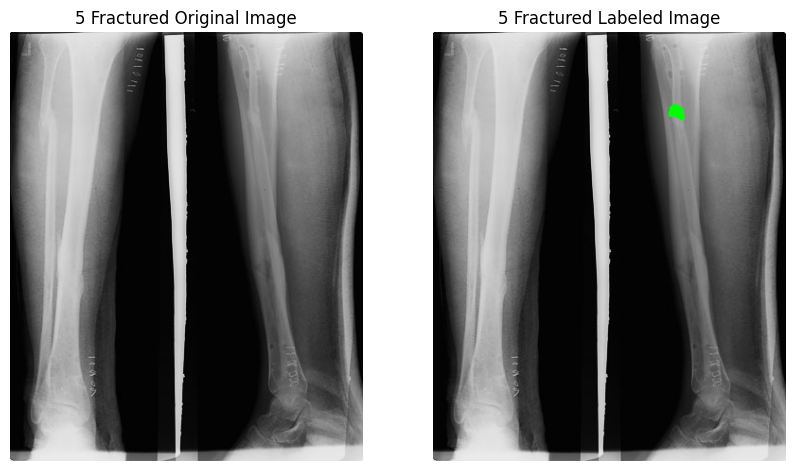

In [69]:
# df[df["fracture_count"] == 5]

image_path = '/home/nas/data/eunju/dataset/FracAtlas/images/Fractured/IMG0002572.jpg'
polygons = get_polygon_from_json(json_data, "IMG0002572.jpg")
visualize_labeled_image(image_path, polygons, 2, "5 Fractured Original Image", "5 Fractured Labeled Image" )

In [73]:
polygons = get_polygon_from_json(json_data, "IMG0002572.jpg")
len(polygons[0][0])

161

# 3. 데이터 전처리
* 기본적인 Segmentation 모델인 U-net에 학습하기 위해서는 Fixed Input Image size를 필요로 합니다.
* input image size = (240, 240)으로 고정하였습니다.
* input image size를 변형 함으로써 label data도 맞추어 주었습니다.

### 3-1. Input Image Size (240x240)
* 여러 shape의 이미지를 (240x240)으로 통일했습니다.
* JPG -> npy

In [52]:
import os
import cv2
import numpy as np

image_folder = './data/All_sorted_dataset'
output_file = 'allnpy240'

image_data = []

for filename in os.listdir(image_folder):
    if filename.endswith('.jpg'):
        img_path = os.path.join(image_folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_resized = cv2.resize(img, (240, 240))  # U-net 모델을 위해 240x240로 리사이즈
        image_data.append(img_resized)

image_data_array = np.array(image_data)  # 리스트를 NumPy 배열로 변환
np.save(output_file, image_data_array)  # npy 파일로 저장

# npy 데이터 load 후 shape 출력
All_npy_240 = np.load("./allnpy240.npy")
print(All_npy_240.shape)

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

(4083, 240, 240)


In [55]:
All_npy_240[0].shape

(240, 240)

In [56]:
import os
import cv2
import numpy as np

image_folder = './data/All_sorted_dataset'
output_file = 'allnpy'

image_data = []

for filename in os.listdir(image_folder):
    if filename.endswith('.jpg'):
        img_path = os.path.join(image_folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # 그레이스케일로 이미지 읽기
        image_data.append(img)  # 리사이즈 없이 원본 이미지 추가

# 이미지 데이터를 NumPy 배열로 변환
image_data_array = np.array(image_data, dtype=object)  # 원본 크기를 유지하려면 dtype=object로 설정

# npy 파일로 저장
np.save(output_file, image_data_array)

# npy 파일을 로드하고 shape 출력
All_npy = np.load(f"./{output_file}.npy", allow_pickle=True)  # allow_pickle=True 필요
print(All_npy.shape)  # 이미지 데이터의 배열 크기 출력


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

(4083,)


In [80]:
image_size = []

for i in range(len(All_npy)):
    image_size.append(All_npy[i].shape)
    
    
print(image_size[205])

(454, 373)


# 골절 데이터의 input image size
* 아래 공식을 통해 resize된 input image의 각 라벨 위치를 변경하였습니다.

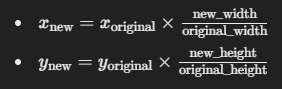

In [82]:
import os
import cv2
import numpy as np

image_folder = './data/images/Fractured'
output_file = 'Fractured_npy'

image_data = []

for filename in os.listdir(image_folder):
    if filename.endswith('.jpg'):
        img_path = os.path.join(image_folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # 그레이스케일로 이미지 읽기
        image_data.append(img)  # 리사이즈 없이 원본 이미지 추가

# 이미지 데이터를 NumPy 배열로 변환
image_data_array = np.array(image_data, dtype=object)  # 원본 크기를 유지하려면 dtype=object로 설정

# npy 파일로 저장
np.save(output_file, image_data_array)

# npy 파일을 로드하고 shape 출력
All_npy = np.load(f"./{output_file}.npy", allow_pickle=True)  # allow_pickle=True 필요
print(All_npy.shape)  # 이미지 데이터의 배열 크기 출력


(717,)


In [86]:
fracture_image_size = []

for i in range(len(All_npy)):
    fracture_image_size.append(All_npy[i].shape)
    
fracture_image_size

[(454, 373),
 (454, 373),
 (373, 454),
 (2880, 2304),
 (454, 373),
 (373, 454),
 (454, 373),
 (454, 373),
 (2880, 2304),
 (2880, 2304),
 (373, 454),
 (454, 373),
 (454, 373),
 (454, 373),
 (454, 373),
 (454, 373),
 (454, 373),
 (373, 454),
 (373, 454),
 (2880, 2304),
 (454, 373),
 (454, 373),
 (2880, 2304),
 (2140, 1760),
 (454, 373),
 (2880, 2304),
 (373, 454),
 (454, 181),
 (454, 373),
 (454, 373),
 (454, 373),
 (454, 373),
 (454, 373),
 (454, 373),
 (373, 454),
 (2880, 2304),
 (454, 373),
 (454, 373),
 (454, 373),
 (454, 373),
 (373, 454),
 (2880, 2304),
 (454, 373),
 (454, 373),
 (2880, 2304),
 (454, 373),
 (454, 373),
 (454, 373),
 (454, 373),
 (454, 373),
 (2880, 2304),
 (373, 454),
 (373, 454),
 (454, 373),
 (454, 373),
 (454, 373),
 (454, 373),
 (454, 373),
 (2880, 2304),
 (454, 373),
 (454, 373),
 (373, 454),
 (454, 373),
 (454, 373),
 (454, 373),
 (454, 373),
 (454, 373),
 (454, 373),
 (373, 454),
 (454, 373),
 (454, 373),
 (373, 454),
 (454, 373),
 (454, 373),
 (454, 373),
 